In [1]:
#프로젝트의 루트 디렉토리를 설정하기 위한 코드
import os
current_dir = os.getcwd()  # 현재 작업 디렉토리
print(os.path.dirname(current_dir))
# print(os.path.dirname(os.path.dirname(current_dir)))
# 루트 경로 설정 (예: 프로젝트 루트 경로)
project_root = os.path.dirname(current_dir)
os.chdir(project_root)  # 루트 경로로 변경

c:\sb-fsts\sb-fsts


In [2]:
import datetime
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import requests
from datetime import timedelta

In [10]:
#예시 데이터
class KisDomesticDailyChartBar:
    def __init__(self, time, open, close, high, low, volume, amount, change):
        self.time = time
        self.open = open
        self.close = close
        self.high = high
        self.low = low
        self.volume = volume
        self.amount = amount
        self.change = change


ohlc = [
    KisDomesticDailyChartBar("2023-01-01T00:00:00+09:00", 100000, 95000, 100000, 95000, 0, 0, 0),
    KisDomesticDailyChartBar("2023-01-02T00:00:00+09:00", 93000, 110000, 115000, 92000, 0, 0, 0),
    KisDomesticDailyChartBar("2023-01-03T00:00:00+09:00", 98000, 120000, 120000, 98000, 0, 0, 0),
    KisDomesticDailyChartBar("2023-01-04T00:00:00+09:00", 172500, 174000, 175000, 171000, 0, 0, 0),
]


In [3]:
from app.utils.auto_trading_bot import AutoTradingBot
from datetime import date, time

user_name = '홍석형'
auto_trading_stock = AutoTradingBot(user_name)

symbol = '336260'

start_date = date(2022, 1, 1)
end_date = date(2024, 12, 1)

auto_trading_stock._get_ohlc(symbol, start_date, end_date)


실전투자 API 객체가 성공적으로 생성되었습니다.


[KisDomesticDailyChartBar(time='2022-01-03T00:00:00+09:00', open=48050, close=48000, high=48350, low=47950, volume=271572, amount=13052212600, change=0),
 KisDomesticDailyChartBar(time='2022-01-04T00:00:00+09:00', open=48000, close=47650, high=48100, low=47400, volume=361839, amount=17241261650, change=-350),
 KisDomesticDailyChartBar(time='2022-01-05T00:00:00+09:00', open=47950, close=47600, high=48400, low=47500, volume=385662, amount=18422342750, change=-50),
 KisDomesticDailyChartBar(time='2022-01-06T00:00:00+09:00', open=46900, close=44050, high=46900, low=44050, volume=1537037, amount=69497621550, change=-3550),
 KisDomesticDailyChartBar(time='2022-01-07T00:00:00+09:00', open=44500, close=44700, high=45050, low=44200, volume=391451, amount=17491533900, change=650),
 KisDomesticDailyChartBar(time='2022-01-10T00:00:00+09:00', open=44700, close=42850, high=44750, low=42650, volume=762577, amount=32904541400, change=-1850),
 KisDomesticDailyChartBar(time='2022-01-11T00:00:00+09:00', 

In [4]:
ohlc = auto_trading_stock._get_ohlc(symbol, start_date, end_date)

In [5]:
def trading_signal_penetrating(ohlc):
    """
    관통형
    매수/매도 신호를 판단하는 함수.
    :param ohlc: 날짜별 OHLC 데이터 (KisDomesticDailyChartBar 객체 리스트)
    :return: 매수 성공 목록과 개별 신호
    """
    results = []  # 전체 결과 저장
    successful_trades = []  # 매수 성공 목록

    if len(ohlc) < 3:
        raise ValueError("3일 이상의 데이터가 필요합니다.")

    for i in range(2, len(ohlc)):
        d_2 = ohlc[i - 2]
        d_1 = ohlc[i - 1]
        current = ohlc[i]

        # D-2 조건
        d_2_condition = d_2.close < d_2.open
        d_2_long_bear = abs(d_2.close - d_2.open) >= (float(d_2.open) * 0.02) # 2%하락으로 계산
        print(f"\n[D-2 조건] 날짜: {d_2.time}")
        print(f"  D-2종가 < D-2시초가: {d_2.close} < {d_2.open} = {d_2_condition}")
        print(f"  장대음봉: |{d_2.close} - {d_2.open}| >= {float(d_2.open) * 0.02} = {d_2_long_bear}")
        # D-1 조건
        d_1_condition = (
            d_1.open < d_2.low and
            d_1.close > d_2.close + (d_2.open - d_2.close) / 2
        )
        print(f"\n[D-1 조건] 날짜: {d_1.time}")
        print(f"  D-1 시초가 < D-2 최저가: {d_1.open} < {d_2.low} = {d_1.open < d_2.low}")
        
        # 모든 조건 충족 여부 확인
        all_conditions_met = d_2_condition and d_2_long_bear and d_1_condition

        if all_conditions_met:
            # 매매 시점 나누기
            buy_signal_d2 = current.close > d_2.high
            buy_signal_d1 = current.close > d_1.high
            print(f"\n[매매 시점] 날짜: {current.time}")
            print(f"  현재 종가 > D-2 최고가: {current.close} > {d_2.high} = {buy_signal_d2}")
            print(f"  현재 종가 > D-1 최고가: {current.close} > {d_1.high} = {buy_signal_d1}")
            
            if buy_signal_d2 or buy_signal_d1:
                # 매수 성공 여부
                buy_condition = "P > D-2.h" if buy_signal_d2 else "P > D-1.h"
                success = True  # 매수 성공

                # 결과 저장
                trade_result = {
                    "날짜": current.time,
                    "매수/매도": "매수신호",
                    "특징": "D-2 장대음봉",
                    "매매시점": buy_condition,
                    "손절조건": "미충족" if current.close >= d_1.low else "충족",
                    "매수 성공 여부": "성공" if success else "실패",
                }
                results.append(trade_result)
                # 매수 성공 목록에 추가
                successful_trades.append(trade_result)
                
            else:
                # 매수 신호는 있으나 성공하지 않음
                results.append({
                    "날짜": current.time,
                    "매수/매도": "매수신호",
                    "특징": "D-2 장대음봉",
                    "매매시점": "미충족",
                    "손절조건": "미충족",
                    "매수 성공 여부": "실패",
                })
        else:
            # 조건 충족하지 않음
            results.append({
                "날짜": current.time,
                "매수/매도": "조건 미충족",
                "특징": "미충족",
                "매매시점": "미충족",
                "손절조건": "미충족",
                "매수 성공 여부": "실패",
            })


        
    return results, successful_trades

# 매수/매도 신호 판단
signals, successful_trades = trading_signal_penetrating(ohlc)

# 전체 신호 출력
print("전체 신호:")
for signal in signals:
    print(signal)

# 매수 성공 목록 출력
print("\n매수 성공 목록:")
for trade in successful_trades:
    print(trade)



[D-2 조건] 날짜: 2022-01-03 00:00:00+09:00
  D-2종가 < D-2시초가: 4.8E+4 < 4.805E+4 = True
  장대음봉: |4.8E+4 - 4.805E+4| >= 961.0 = False

[D-1 조건] 날짜: 2022-01-04 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.8E+4 < 4.795E+4 = False

[D-2 조건] 날짜: 2022-01-04 00:00:00+09:00
  D-2종가 < D-2시초가: 4.765E+4 < 4.8E+4 = True
  장대음봉: |4.765E+4 - 4.8E+4| >= 960.0 = False

[D-1 조건] 날짜: 2022-01-05 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.795E+4 < 4.74E+4 = False

[D-2 조건] 날짜: 2022-01-05 00:00:00+09:00
  D-2종가 < D-2시초가: 4.76E+4 < 4.795E+4 = True
  장대음봉: |4.76E+4 - 4.795E+4| >= 959.0 = False

[D-1 조건] 날짜: 2022-01-06 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.69E+4 < 4.75E+4 = True

[D-2 조건] 날짜: 2022-01-06 00:00:00+09:00
  D-2종가 < D-2시초가: 4.405E+4 < 4.69E+4 = True
  장대음봉: |4.405E+4 - 4.69E+4| >= 938.0 = True

[D-1 조건] 날짜: 2022-01-07 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.45E+4 < 4.405E+4 = False

[D-2 조건] 날짜: 2022-01-07 00:00:00+09:00
  D-2종가 < D-2시초가: 4.47E+4 < 4.45E+4 = False
  장대음봉: |4.47E+4 - 4.45E+4| >= 890.0 = False

[D-1 조

In [44]:
import math
import matplotlib.pyplot as plt

def simulate_trading(ohlc, start_date, end_date, initial_cash=10000000, trade_amount=1000000):
    """
    상승장악형2 매매 시뮬레이션 함수 (순회 방식, 손절/익절 구분)
    """
    cash = initial_cash
    holdings = 0
    trades = []
    signals, successful_trades = trading_signal_penetrating(ohlc)
    
    previous_data = None  # 전날 데이터를 추적

    for current_data in ohlc:
        date = current_data.time

        # 날짜가 범위 내에 있는 경우만 처리
        if not (start_date <= date <= end_date):
            previous_data = current_data  # 다음 루프로 넘어가기 전에 전날 데이터 업데이트
            continue

        # 매수 처리 (신호와 매수 가능 여부 확인)
        signal = next((s for s in signals if s["날짜"] == date), None)
        if signal and signal["매수 성공 여부"] == "성공" and cash >= trade_amount:
            if previous_data:  # 전날 데이터가 있는 경우에만 처리
                buy_price = current_data.close
                stop_loss_price = previous_data.low  # 전날 최저가를 손절가로 사용
                target_price = buy_price + 2 * (buy_price - stop_loss_price)
                quantity = math.floor(trade_amount / buy_price)
                
                trades.append({
                    "날짜": date,
                    "종류": "매수",
                    "가격": buy_price,
                    "수량": quantity,
                    "목표가": target_price,
                    "손절가": stop_loss_price,
                })
                cash -= buy_price * quantity
                holdings += quantity

        # 매도 처리
        for trade in trades:
            if trade["종류"] == "매수" and trade["수량"] > 0:
                current_price = current_data.close
                if current_price >= trade["목표가"]:
                    # 익절 매도
                    cash += trade["수량"] * current_price
                    holdings -= trade["수량"]
                    trades.append({
                        "날짜": trade["날짜"],
                        "종류": "익절 매도",
                        "매도 날짜": date,
                        "매도 가격": current_price,
                        "수량": trade["수량"]
                    })
                    trade["수량"] = 0
                elif current_price <= trade["손절가"]:
                    # 손절 매도
                    cash += trade["수량"] * current_price
                    holdings -= trade["수량"]
                    trades.append({
                        "날짜": trade["날짜"],
                        "종류": "손절 매도",
                        "매도 날짜": date,
                        "매도 가격": current_price,
                        "수량": trade["수량"]
                    })
                    trade["수량"] = 0

        # 전날 데이터 업데이트
        previous_data = current_data

    # 결과 정리
    final_assets = cash + holdings * ohlc[-1].close if ohlc else cash
    
    return trades, final_assets


In [45]:
simulate_trading(ohlc,start_date,end_date)


[D-2 조건] 날짜: 2022-01-03 00:00:00+09:00
  D-2종가 < D-2시초가: 4.8E+4 < 4.805E+4 = True
  장대음봉: |4.8E+4 - 4.805E+4| >= 961.0 = False

[D-1 조건] 날짜: 2022-01-04 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.8E+4 < 4.795E+4 = False

[D-2 조건] 날짜: 2022-01-04 00:00:00+09:00
  D-2종가 < D-2시초가: 4.765E+4 < 4.8E+4 = True
  장대음봉: |4.765E+4 - 4.8E+4| >= 960.0 = False

[D-1 조건] 날짜: 2022-01-05 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.795E+4 < 4.74E+4 = False

[D-2 조건] 날짜: 2022-01-05 00:00:00+09:00
  D-2종가 < D-2시초가: 4.76E+4 < 4.795E+4 = True
  장대음봉: |4.76E+4 - 4.795E+4| >= 959.0 = False

[D-1 조건] 날짜: 2022-01-06 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.69E+4 < 4.75E+4 = True

[D-2 조건] 날짜: 2022-01-06 00:00:00+09:00
  D-2종가 < D-2시초가: 4.405E+4 < 4.69E+4 = True
  장대음봉: |4.405E+4 - 4.69E+4| >= 938.0 = True

[D-1 조건] 날짜: 2022-01-07 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.45E+4 < 4.405E+4 = False

[D-2 조건] 날짜: 2022-01-07 00:00:00+09:00
  D-2종가 < D-2시초가: 4.47E+4 < 4.45E+4 = False
  장대음봉: |4.47E+4 - 4.45E+4| >= 890.0 = False

[D-1 조

([{'날짜': datetime.datetime(2023, 1, 9, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='Asia/Seoul')),
   '종류': '매수',
   '가격': Decimal('3.12E+4'),
   '수량': 0,
   '목표가': Decimal('-2.30E+3'),
   '손절가': Decimal('4.795E+4')},
  {'날짜': datetime.datetime(2023, 1, 9, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='Asia/Seoul')),
   '종류': '익절 매도',
   '매도 날짜': datetime.datetime(2023, 1, 9, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='Asia/Seoul')),
   '매도 가격': Decimal('3.12E+4'),
   '수량': 32},
  {'날짜': datetime.datetime(2023, 7, 31, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='Asia/Seoul')),
   '종류': '매수',
   '가격': Decimal('2.72E+4'),
   '수량': 0,
   '목표가': Decimal('-1.430E+4'),
   '손절가': Decimal('4.795E+4')},
  {'날짜': datetime.datetime(2023, 7, 31, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='Asia/Seoul')),
   '종류': '익절 매도',
   '매도 날짜': datetime.datetime(2023, 7, 31, 0, 0, tzinfo=zoneinfo.ZoneInfo(key='Asia/Seoul')),
   '매도 가격': Decimal('2.72E+4'),
   '수량': 36}],
 Decimal('10000000'))

In [17]:
def engulfing1(ohlc):
    """
    상승장악형1 매수/매도 신호를 판단하는 함수.
    :param ohlc: 날짜별 OHLC 데이터 (KisDomesticDailyChartBar 객체 리스트)
    :return: 매수 성공 목록과 개별 신호
    """
    results = []  # 전체 결과 저장
    successful_trades = []  # 매수 성공 목록

    if len(ohlc) < 3:
        raise ValueError("3일 이상의 데이터가 필요합니다.")

    for i in range(2, len(ohlc)):
        d_2 = ohlc[i - 2]  # D-2 데이터
        d_1 = ohlc[i - 1]  # D-1 데이터
        current = ohlc[i]  # 당일 데이터

        # D-2 조건 디버깅 (음봉)
        d_2_condition = d_2.close < d_2.open
        print(f"\n[D-2 조건] 날짜: {d_2.time}")
        print(f"  종가 < 시초가: {d_2.close} < {d_2.open} = {d_2_condition}")

        # D-1 조건 디버깅
        d_1_condition = (
            d_1.open < d_2.low and
            d_1.close > d_2.high
        )
        print(f"\n[D-1 조건] 날짜: {d_1.time}")
        print(f"  시초가 < D-2 최저가: {d_1.open} < {d_2.low} = {d_1.open < d_2.low}")
        print(f"  종가 > D-2 최고가: {d_1.close} > {d_2.high} = {d_1.close > d_2.high}")

        # 매매 시점 디버깅
        buy_signal = current.close > d_1.high
        print(f"\n[매매 시점] 날짜: {current.time}")
        print(f"  종가 > D-1 최고가: {current.close} > {d_1.high} = {buy_signal}")

        # 손절 조건 디버깅
        stoploss = current.close < d_1.low
        print(f"\n[손절 조건] 날짜: {current.time}")
        print(f"  종가 < D-1 최저가: {current.close} < {d_1.low} = {stoploss}")

        # 모든 조건 충족 여부 확인
        all_conditions_met = d_2_condition and d_1_condition
        print(f"\n[전체 조건 충족 여부] 날짜: {current.time}")
        print(f"  D-2 조건: {d_2_condition}")
        print(f"  D-1 조건: {d_1_condition}")
        print(f"  모든 조건 충족: {all_conditions_met}")

        if all_conditions_met:
            if buy_signal:
                trade_result = {
                    "날짜": current.time,
                    "매수/매도": "매수신호",
                    "특징": "상승장악형1",
                    "매매시점": "P > H",
                    "손절조건": "미충족" if not stoploss else "충족",
                    "매수 성공 여부": "성공",
                }
                results.append(trade_result)
                successful_trades.append(trade_result)
            else:
                results.append({
                    "날짜": current.time,
                    "매수/매도": "매수신호",
                    "특징": "상승장악형1",
                    "매매시점": "미충족",
                    "손절조건": "미충족" if not stoploss else "충족",
                    "매수 성공 여부": "실패",
                })
        else:
            results.append({
                "날짜": current.time,
                "매수/매도": "조건 미충족",
                "특징": "미충족",
                "매매시점": "미충족",
                "손절조건": "미충족",
                "매수 성공 여부": "실패",
            })

    return results, successful_trades

# 매수/매도 신호 판단
signals, successful_trades = engulfing1(ohlc)

# 전체 신호 출력
print("\n전체 신호:")
for signal in signals:
    print(signal)

# 매수 성공 목록 출력
print("\n매수 성공 목록:")
for trade in successful_trades:
    print(trade)



[D-2 조건] 날짜: 2023-06-01 00:00:00+09:00
  종가 < 시초가: 3.015E+4 < 3.1E+4 = True

[D-1 조건] 날짜: 2023-06-02 00:00:00+09:00
  시초가 < D-2 최저가: 3.05E+4 < 3.01E+4 = False
  종가 > D-2 최고가: 3.095E+4 > 3.12E+4 = False

[매매 시점] 날짜: 2023-06-05 00:00:00+09:00
  종가 > D-1 최고가: 3.09E+4 > 3.1E+4 = False

[손절 조건] 날짜: 2023-06-05 00:00:00+09:00
  종가 < D-1 최저가: 3.09E+4 < 3.02E+4 = False

[전체 조건 충족 여부] 날짜: 2023-06-05 00:00:00+09:00
  D-2 조건: True
  D-1 조건: False
  모든 조건 충족: False

[D-2 조건] 날짜: 2023-06-02 00:00:00+09:00
  종가 < 시초가: 3.095E+4 < 3.05E+4 = False

[D-1 조건] 날짜: 2023-06-05 00:00:00+09:00
  시초가 < D-2 최저가: 3.11E+4 < 3.02E+4 = False
  종가 > D-2 최고가: 3.09E+4 > 3.1E+4 = False

[매매 시점] 날짜: 2023-06-07 00:00:00+09:00
  종가 > D-1 최고가: 3.08E+4 > 3.12E+4 = False

[손절 조건] 날짜: 2023-06-07 00:00:00+09:00
  종가 < D-1 최저가: 3.08E+4 < 3.07E+4 = False

[전체 조건 충족 여부] 날짜: 2023-06-07 00:00:00+09:00
  D-2 조건: False
  D-1 조건: False
  모든 조건 충족: False

[D-2 조건] 날짜: 2023-06-05 00:00:00+09:00
  종가 < 시초가: 3.09E+4 < 3.11E+4 = True

[D-1

In [ ]:
# 시뮬레이션 실행
trade_value = 1000000  # 매매 금액
trading_history, buy_signals, sell_signals, timestamps = simulate_penetrating_trading(ohlc, trade_value)

# 최종 결과 출력
print("\n[최종 매매 기록]")
for trade in trading_history['history']:
    print(trade)


In [ ]:
def engulfing_logic2(ohlc):
        """
        상승장악형2 매매 로직.
        :return: 매수 성공 목록과 개별 신호
        """
        results = []
        successful_trades = []

        if len(ohlc) < 2:
            raise ValueError("2일 이상의 데이터가 필요합니다.")

        for i in range(1, len(ohlc)):
            d_1 = ohlc[i - 1]  # D-1 데이터
            current = ohlc[i]  # 당일 데이터

            # D-1 조건: D-1 종가 < D-1 시초가 (음봉)
            d_1_condition = d_1.close < d_1.open
            print(f"\n[D-1 조건] 날짜: {d_1.time}")
            print(f"  종가 < 시초가: {d_1.close} < {d_1.open} = {d_1_condition}")

            # 매매 시점 조건
            buy_signal = current.open < d_1.low and current.close > d_1.high
            print(f"\n[매매 시점] 날짜: {current.time}")
            print(f"  당일 시가 < D-1 최저가: {current.open} < {d_1.low} = {current.open < d_1.low}")
            print(f"  당일 종가 > D-1 최고가: {current.close} > {d_1.high} = {current.close > d_1.high}")

            # 손절 조건
            stoploss = current.close < d_1.low
            print(f"\n[손절 조건] 날짜: {current.time}")
            print(f"  종가 < D-1 최저가: {current.close} < {d_1.low} = {stoploss}")

            # 모든 조건 충족 여부 확인
            all_conditions_met = d_1_condition
            print(f"\n[전체 조건 충족 여부] 날짜: {current.time}")
            print(f"  D-1 조건: {d_1_condition}")
            print(f"  모든 조건 충족: {all_conditions_met}")

            if all_conditions_met:
                if buy_signal:
                    trade_result = {
                        "날짜": current.time,
                        "매수/매도": "매수신호",
                        "특징": "상승장악형2",
                        "매매시점": "SS < L and P > H",
                        "손절조건": "미충족" if not stoploss else "충족",
                        "매수 성공 여부": "성공",
                    }
                    results.append(trade_result)
                    successful_trades.append(trade_result)
                else:
                    results.append({
                        "날짜": current.time,
                        "매수/매도": "매수신호",
                        "특징": "상승장악형2",
                        "매매시점": "미충족",
                        "손절조건": "미충족" if not stoploss else "충족",
                        "매수 성공 여부": "실패",
                    })
            else:
                results.append({
                    "날짜": current.time,
                    "매수/매도": "조건 미충족",
                    "특징": "미충족",
                    "매매시점": "미충족",
                    "손절조건": "미충족",
                    "매수 성공 여부": "실패",
                })

        return results, successful_trades
    
    # 매수/매도 신호 판단
signals, successful_trades = engulfing_logic2(ohlc)

# 전체 신호 출력
print("\n전체 신호:")
for signal in signals:
    print(signal)

# 매수 성공 목록 출력
print("\n매수 성공 목록:")
for trade in successful_trades:
    print(trade)

In [ ]:
def counterattack_logic(ohlc):
        """
        상승 반격형 매매 로직.
        :return: 매수 성공 목록과 개별 신호
        """
        results = []
        successful_trades = []

        if len(ohlc) < 3:
            raise ValueError("3일 이상의 데이터가 필요합니다.")

        for i in range(2, len(ohlc)):
            d_2 = ohlc[i - 2]  # D-2 데이터
            d_1 = ohlc[i - 1]  # D-1 데이터
            current = ohlc[i]  # 당일 데이터

            # D-2 조건
            d_2_condition = d_2.close < d_2.open

            # D-1 조건
            midpoint = d_2.close + (d_2.open - d_2.close) / 2
            d_1_condition = (
                d_1.open < d_2.low and
                d_2.close <= d_1.close <= midpoint
            )

            # 매매 시점
            buy_signal = current.close > d_2.high

            # 손절 조건
            stoploss = current.close < d_2.low

            # 모든 조건 충족 여부 확인
            all_conditions_met = d_2_condition and d_1_condition

            if all_conditions_met:
                if buy_signal:
                    trade_result = {
                        "날짜": current.time,
                        "매수/매도": "매수신호",
                        "특징": "상승 반격형",
                        "매매시점": "P > h",
                        "손절조건": "미충족" if not stoploss else "충족",
                        "매수 성공 여부": "성공",
                    }
                    results.append(trade_result)
                    successful_trades.append(trade_result)
                else:
                    results.append({
                        "날짜": current.time,
                        "매수/매도": "매수신호",
                        "특징": "상승 반격형",
                        "매매시점": "미충족",
                        "손절조건": "미충족" if not stoploss else "충족",
                        "매수 성공 여부": "실패",
                    })
            else:
                results.append({
                    "날짜": current.time,
                    "매수/매도": "조건 미충족",
                    "특징": "미충족",
                    "매매시점": "미충족",
                    "손절조건": "미충족",
                    "매수 성공 여부": "실패",
                })

        return results, successful_trades
    
        # 매수/매도 신호 판단
signals, successful_trades = counterattack_logic(ohlc)

# 전체 신호 출력
print("\n전체 신호:")
for signal in signals:
    print(signal)

# 매수 성공 목록 출력
print("\n매수 성공 목록:")
for trade in successful_trades:
    print(trade)
    
    

In [11]:
def doji_star_logic(ohlc):
        """
        상승 도지 스타 매매 로직.
        :return: 매수 성공 목록과 개별 신호
        """
        results = []
        successful_trades = []

        if len(ohlc) < 3:
            raise ValueError("3일 이상의 데이터가 필요합니다.")

        for i in range(2, len(ohlc)):
            d_2 = ohlc[i - 2]  # D-2 데이터
            d_1 = ohlc[i - 1]  # D-1 데이터
            current = ohlc[i]  # 당일 데이터

            # D-2 조건: D-2 종가 < D-2 시초가 (음봉)
            d_2_condition = d_2.close < d_2.open
            print(f"\n[D-2 조건] 날짜: {d_2.time}")
            print(f"  D-2 종가 < D-2 시초가: {d_2.close} < {d_2.open} = {d_2_condition}")

            # D-1 조건
            d_1_condition = (
                d_1.close == d_1.open and  # 도지 조건
                d_1.open < d_2.low         # D-1 시초가 < D-2 최저가
            )
            print(f"\n[D-1 조건] 날짜: {d_1.time}")
            print(f"  D-1 종가 = D-1 시초가: {d_1.close} == {d_1.open} = {d_1.close == d_1.open}")
            print(f"  D-1 시초가 < D-2 최저가: {d_1.open} < {d_2.low} = {d_1.open < d_2.low}")

            # 매매 시점: 당일 종가 > D-2 최고가
            buy_signal = current.close > d_2.high
            print(f"\n[매매 시점] 날짜: {current.time}")
            print(f"  당일 종가 > D-2 최고가: {current.close} > {d_2.high} = {buy_signal}")

            # 손절 조건: 당일 종가 < D-1 최저가
            stoploss = current.close < d_1.low
            print(f"\n[손절 조건] 날짜: {current.time}")
            print(f"  당일 종가 < D-1 최저가: {current.close} < {d_1.low} = {stoploss}")

            # 모든 조건 충족 여부 확인
            all_conditions_met = d_2_condition and d_1_condition
            print(f"\n[전체 조건 충족 여부] 날짜: {current.time}")
            print(f"  D-2 조건: {d_2_condition}")
            print(f"  D-1 조건: {d_1_condition}")
            print(f"  모든 조건 충족: {all_conditions_met}")

            if all_conditions_met:
                if buy_signal:
                    trade_result = {
                        "날짜": current.time,
                        "매수/매도": "매수신호",
                        "특징": "상승 도지 스타",
                        "매매시점": "P > h",
                        "손절조건": "미충족" if not stoploss else "충족",
                        "매수 성공 여부": "성공",
                    }
                    results.append(trade_result)
                    successful_trades.append(trade_result)
                else:
                    results.append({
                        "날짜": current.time,
                        "매수/매도": "매수신호",
                        "특징": "상승 도지 스타",
                        "매매시점": "미충족",
                        "손절조건": "미충족" if not stoploss else "충족",
                        "매수 성공 여부": "실패",
                    })
            else:
                results.append({
                    "날짜": current.time,
                    "매수/매도": "조건 미충족",
                    "특징": "미충족",
                    "매매시점": "미충족",
                    "손절조건": "미충족",
                    "매수 성공 여부": "실패",
                })

        return results, successful_trades
    
            # 매수/매도 신호 판단
signals, successful_trades = doji_star_logic(ohlc)

# 전체 신호 출력
print("\n전체 신호:")
for signal in signals:
    print(signal)

# 매수 성공 목록 출력
print("\n매수 성공 목록:")
for trade in successful_trades:
    print(trade)    


[D-2 조건] 날짜: 2022-01-03 00:00:00+09:00
  D-2 종가 < D-2 시초가: 4.8E+4 < 4.805E+4 = True

[D-1 조건] 날짜: 2022-01-04 00:00:00+09:00
  D-1 종가 = D-1 시초가: 4.765E+4 == 4.8E+4 = False
  D-1 시초가 < D-2 최저가: 4.8E+4 < 4.795E+4 = False

[매매 시점] 날짜: 2022-01-05 00:00:00+09:00
  당일 종가 > D-2 최고가: 4.76E+4 > 4.835E+4 = False

[손절 조건] 날짜: 2022-01-05 00:00:00+09:00
  당일 종가 < D-1 최저가: 4.76E+4 < 4.74E+4 = False

[전체 조건 충족 여부] 날짜: 2022-01-05 00:00:00+09:00
  D-2 조건: True
  D-1 조건: False
  모든 조건 충족: False

[D-2 조건] 날짜: 2022-01-04 00:00:00+09:00
  D-2 종가 < D-2 시초가: 4.765E+4 < 4.8E+4 = True

[D-1 조건] 날짜: 2022-01-05 00:00:00+09:00
  D-1 종가 = D-1 시초가: 4.76E+4 == 4.795E+4 = False
  D-1 시초가 < D-2 최저가: 4.795E+4 < 4.74E+4 = False

[매매 시점] 날짜: 2022-01-06 00:00:00+09:00
  당일 종가 > D-2 최고가: 4.405E+4 > 4.81E+4 = False

[손절 조건] 날짜: 2022-01-06 00:00:00+09:00
  당일 종가 < D-1 최저가: 4.405E+4 < 4.75E+4 = True

[전체 조건 충족 여부] 날짜: 2022-01-06 00:00:00+09:00
  D-2 조건: True
  D-1 조건: False
  모든 조건 충족: False

[D-2 조건] 날짜: 2022-01-05 00:00:00+

In [ ]:
def simulate_trading_with_morning_star(ohlc_data, trade_value):
    """
    샛별형 매매 시뮬레이션 (실현 손익 계산 제외).
    :param ohlc_data: OHLC 데이터 (KisDomesticDailyChartBar 객체 리스트)
    :param trade_value: 매매에 사용할 금액 (KRW)
    :return: 매매 기록 및 매수/매도 신호
    """
    # 초기화
    trading_history = {
        'history': [],  # 매매 기록
    }

    # 시뮬레이션 데이터 저장
    buy_signals = []
    sell_signals = []
    timestamps = []

    # 시뮬레이션 실행
    for i in range(2, len(ohlc_data)):
        d_2 = ohlc_data[i - 2]
        d_1 = ohlc_data[i - 1]
        current = ohlc_data[i]

        # 샛별형 매수 조건
        d_2_condition = d_2.close < d_2.open  # D-2 음봉
        d_2_long_bear = abs(d_2.close - d_2.open) >= (float(d_2.open) * 0.02)  # 장대음봉

        d_1_condition = (
            d_2.close > d_1.close > d_1.open  # D-2 종가 > D-1 종가 > D-1 시초가
        )

        # 매매 시점 조건
        buy_signal_low = current.low > d_1.close  # LL(오늘 최저가) > E(D-1 종가)
        buy_signal_high = current.close > d_2.high  # P > h

        all_conditions_met = d_2_condition and d_2_long_bear and d_1_condition

        if all_conditions_met and (buy_signal_low or buy_signal_high):
            # 매수
            buy_price = float(current.open)  # 매수가는 당일 시초가로 설정
            stop_loss = float(d_1.low)  # stop loss는 D-2 최저가
            quantity = math.floor(trade_value / buy_price)
            if quantity > 0:
                trading_history['history'].append({
                    'position': 'BUY',
                    'price': buy_price,
                    'quantity': quantity,
                    'stop_loss': stop_loss,
                })

                # 매수 신호 기록
                buy_signals.append((current.time, buy_price))
                timestamps.append(current.time)
                print(f"샛별형 매수 시점: {current.time}, 매수가: {buy_price}, 매수량: {quantity}, 손절가: {stop_loss}")

        # 매도 조건 확인 및 실행
        for trade in trading_history['history']:
            if trade['position'] == 'BUY' and trade['quantity'] > 0:  # 매수 수량이 있어야 매도 가능
                target_price = trade['price'] + 2 * (trade['price'] - trade['stop_loss'])
                if current.close <= trade['stop_loss']:
                    # 손절 매도
                    sell_quantity = trade['quantity']  # 매도 수량은 남은 매수 수량만큼
                    sell_price = float(trade['stop_loss'])
                    trading_history['history'].append({
                        'position': 'SELL',
                        'price': sell_price,
                        'quantity': sell_quantity,
                    })
                    sell_signals.append((current.time, sell_price))
                    print(f"손절 매도: {current.time}, 매도가: {sell_price}, 매도량: {sell_quantity}")
                    trade['quantity'] = 0  # 남은 수량 감소
                elif current.close >= target_price:
                    # 목표 수익 매도
                    sell_quantity = trade['quantity']  # 매도 수량은 남은 매수 수량만큼
                    sell_price = float(target_price)
                    trading_history['history'].append({
                        'position': 'SELL',
                        'price': sell_price,
                        'quantity': sell_quantity,
                    })
                    sell_signals.append((current.time, sell_price))
                    print(f"목표 매도: {current.time}, 매도가: {sell_price}, 매도량: {sell_quantity}")
                    trade['quantity'] = 0  # 남은 수량 감소

    return trading_history, buy_signals, sell_signals, timestamps

trade_value = 1000000
            # 매수/매도 신호 판단
trading_history, buy_signals, sell_signals, timestamps = simulate_trading_with_morning_star(ohlc,trade_value)



# 최종 결과 출력
print("\n[최종 매매 기록]")
for trade in trading_history['history']:
    print(trade)

In [ ]:
def harami_logic(ohlc):
        """
        상승 잉태형 매매 로직.
        :return: 매수 성공 목록과 개별 신호
        """
        results = []
        successful_trades = []

        if len(ohlc) < 3:
            raise ValueError("3일 이상의 데이터가 필요합니다.")

        for i in range(2, len(ohlc)):
            d_2 = ohlc[i - 2]  # D-2 데이터
            d_1 = ohlc[i - 1]  # D-1 데이터
            current = ohlc[i]  # 당일 데이터

            # D-2 조건
            d_2_condition = d_2.close < d_2.open

            # D-1 조건
            d_1_condition = (
                d_1.close > d_2.close >= d_1.open and
                d_1.high < d_2.open and
                d_1.low > d_2.close
            )

            # 매매 시점
            buy_signal = current.close > d_2.high

            # 손절 조건
            stoploss = current.close < d_2.low

            # 모든 조건 충족 여부 확인
            all_conditions_met = d_2_condition and d_1_condition

            if all_conditions_met:
                if buy_signal:
                    trade_result = {
                        "날짜": current.time,
                        "매수/매도": "매수신호",
                        "특징": "상승 잉태형",
                        "매매시점": "P > h",
                        "손절조건": "미충족" if not stoploss else "충족",
                        "매수 성공 여부": "성공",
                    }
                    results.append(trade_result)
                    successful_trades.append(trade_result)
                else:
                    results.append({
                        "날짜": current.time,
                        "매수/매도": "매수신호",
                        "특징": "상승 잉태형",
                        "매매시점": "미충족",
                        "손절조건": "미충족" if not stoploss else "충족",
                        "매수 성공 여부": "실패",
                    })
            else:
                results.append({
                    "날짜": current.time,
                    "매수/매도": "조건 미충족",
                    "특징": "미충족",
                    "매매시점": "미충족",
                    "손절조건": "미충족",
                    "매수 성공 여부": "실패",
                })

        return results, successful_trades
    
            # 매수/매도 신호 판단
signals, successful_trades = harami_logic(ohlc)

# 전체 신호 출력
print("\n전체 신호:")
for signal in signals:
    print(signal)

# 매수 성공 목록 출력
print("\n매수 성공 목록:")
for trade in successful_trades:
    print(trade)

In [33]:
import math
import matplotlib.pyplot as plt
from datetime import timedelta
def simulate_trading(ohlc, start_date, end_date, initial_cash=10000000, trade_amount=1000000):
    """
    상승장악형2 매매 시뮬레이션 함수 (속성 접근 방식, 손절/익절 구분)
    """
    cash = initial_cash
    holdings = 0
    trades = []
    signals, successful_trades = trading_signal_penetrating(ohlc)

    for signal in signals:
        date = signal["날짜"]

        # 매수 처리
        if signal["매수 성공 여부"] == "성공" and cash >= trade_amount:
            current_data = next(d for d in ohlc if d.time == date)
            # 바로 전날 데이터 찾기
            # 전날 데이터 찾기
            previous_data = next((d for d in sorted(ohlc, key=lambda x: x.time) if d.time < date), None)
            
            if not previous_data:
                print(f"전날 데이터가 없습니다. 날짜: {date}")
                continue  # 전날 데이터가 없으면
            
            buy_price = current_data.close
            stop_loss_price = previous_data.low
            target_price = buy_price + 2 * (buy_price - stop_loss_price)
            
            quantity = math.floor(trade_amount / buy_price)
            trades.append({
                "날짜": date,
                "종류": "매수",
                "가격": buy_price,
                "수량": quantity,
                "목표가": target_price,
                "손절가": stop_loss_price,
            })
            cash -= buy_price * quantity
            holdings += quantity

        # 매도 처리
        for trade in trades:
            if trade["종류"] == "매수" and trade["수량"] > 0:
                current_data = next((d for d in ohlc if d.time == date), None)
                if current_data:
                    current_price = current_data.close
                    if current_price >= trade["목표가"]:
                        # 익절 매도
                        cash += trade["수량"] * current_price
                        holdings -= trade["수량"]
                        trades.append({
                            "날짜": trade["날짜"],
                            "종류": "익절 매도",
                            "매도 날짜": current_data.time,
                            "매도 가격": current_price,
                            "수량": trade["수량"]
                        })
                        trade["수량"] = 0
                    elif current_price <= trade["손절가"]:
                        # 손절 매도
                        cash += trade["수량"] * current_price
                        holdings -= trade["수량"]
                        trades.append({
                            "날짜": trade["날짜"],
                            "종류": "손절 매도",
                            "매도 날짜": current_data.time,
                            "매도 가격": current_price,
                            "수량": trade["수량"]
                        })
                        trade["수량"] = 0

    # 결과 정리
    final_assets = cash + holdings * ohlc[-1].close
    
    return trades, final_assets


def plot_trading_signals(ohlc, trades):
    """
    매매 신호와 결과를 차트에 시각화 (속성 접근 방식, 손절/익절 구분)
    """
    dates = [data.time for data in ohlc]
    close_prices = [data.close for data in ohlc]

    plt.figure(figsize=(12, 6))
    plt.plot(dates, close_prices, label='Close Price', alpha=0.7)
    
    buy_plotted = False
    sell_plotted = {"익절": False, "손절": False}
    
    for trade in trades:
        if trade["종류"] == "매수" and not buy_plotted:
            plt.scatter(trade["날짜"], trade["가격"], color='green', label='Buy Signal', marker='^', s=100)
            buy_plotted = True
        elif trade["종류"] == "매수":
            plt.scatter(trade["날짜"], trade["가격"], color='green', marker='^', s=100)
        
        if trade["종류"] == "익절 매도" and not sell_plotted["익절"]:
            plt.scatter(trade["매도 날짜"], trade["매도 가격"], color='blue', label='Take Profit', marker='v', s=100)
            sell_plotted["익절"] = True
        elif trade["종류"] == "익절 매도":
            plt.scatter(trade["매도 날짜"], trade["매도 가격"], color='blue', marker='v', s=100)
        
        if trade["종류"] == "손절 매도" and not sell_plotted["손절"]:
            plt.scatter(trade["매도 날짜"], trade["매도 가격"], color='red', label='Stop Loss', marker='x', s=100)
            sell_plotted["손절"] = True
        elif trade["종류"] == "손절 매도":
            plt.scatter(trade["매도 날짜"], trade["매도 가격"], color='red', marker='x', s=100)
    
    plt.title('Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


In [34]:
# 시뮬레이션 실행

trades, final_assets = simulate_trading(ohlc, start_date, end_date)

print("최종 거래 기록:")
for trade in trades:
    print(trade)

print(f"최종 자산: {final_assets}")


[D-2 조건] 날짜: 2022-01-03 00:00:00+09:00
  D-2종가 < D-2시초가: 4.8E+4 < 4.805E+4 = True
  장대음봉: |4.8E+4 - 4.805E+4| >= 961.0 = False

[D-1 조건] 날짜: 2022-01-04 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.8E+4 < 4.795E+4 = False

[D-2 조건] 날짜: 2022-01-04 00:00:00+09:00
  D-2종가 < D-2시초가: 4.765E+4 < 4.8E+4 = True
  장대음봉: |4.765E+4 - 4.8E+4| >= 960.0 = False

[D-1 조건] 날짜: 2022-01-05 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.795E+4 < 4.74E+4 = False

[D-2 조건] 날짜: 2022-01-05 00:00:00+09:00
  D-2종가 < D-2시초가: 4.76E+4 < 4.795E+4 = True
  장대음봉: |4.76E+4 - 4.795E+4| >= 959.0 = False

[D-1 조건] 날짜: 2022-01-06 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.69E+4 < 4.75E+4 = True

[D-2 조건] 날짜: 2022-01-06 00:00:00+09:00
  D-2종가 < D-2시초가: 4.405E+4 < 4.69E+4 = True
  장대음봉: |4.405E+4 - 4.69E+4| >= 938.0 = True

[D-1 조건] 날짜: 2022-01-07 00:00:00+09:00
  D-1 시초가 < D-2 최저가: 4.45E+4 < 4.405E+4 = False

[D-2 조건] 날짜: 2022-01-07 00:00:00+09:00
  D-2종가 < D-2시초가: 4.47E+4 < 4.45E+4 = False
  장대음봉: |4.47E+4 - 4.45E+4| >= 890.0 = False

[D-1 조

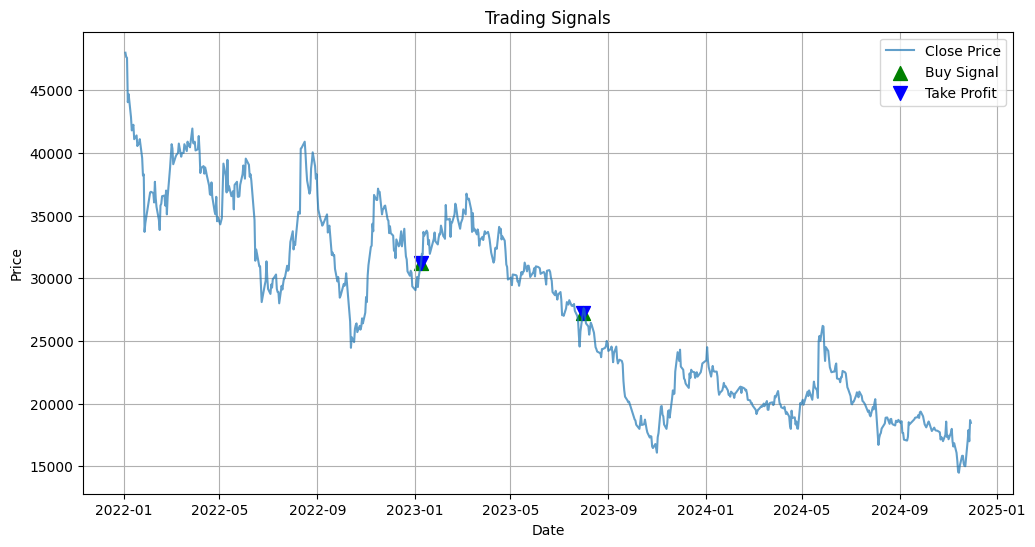

In [24]:
# 차트 시각화
plot_trading_signals(ohlc, trades)